In [6]:
!pip install einops sklearn python-Levenshtein datasets timm jiwer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.4 MB/s eta 0:00:00


In [7]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)

processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')
torch.cuda.empty_cache()

cpu


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [39]:

import datasets

dataset = datasets.load_dataset("keremberke/license-plate-object-detection", 'mini')  # Replace with actual dataset name
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
})

In [9]:
for idx in range(len(dataset["train"])):  # Loop only through available samples
    sample = dataset["train"][idx]
    print(f"🔍 Image ID: {sample['image_id']}")
    print(f"📸 Image: {sample['image']}")
    print(f"✅ Ground Truth Label: {sample['objects']}")  # Check if this is correct


🔍 Image ID: 1480
📸 Image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303 at 0x7E32A981B850>
✅ Ground Truth Label: {'id': [1546], 'area': [728], 'bbox': [[250.0, 162.0, 56.0, 13.0]], 'category': [0]}
🔍 Image ID: 1457
📸 Image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x360 at 0x7E32A9660690>
✅ Ground Truth Label: {'id': [1517], 'area': [1550], 'bbox': [[180.0, 249.0, 62.0, 25.0]], 'category': [0]}
🔍 Image ID: 223
📸 Image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303 at 0x7E32A961E1D0>
✅ Ground Truth Label: {'id': [234], 'area': [4949], 'bbox': [[249.0, 186.0, 101.0, 49.0]], 'category': [0]}


In [10]:
ds_train = dataset["train"]
ds_test = dataset["test"]
ds_val = dataset["validation"]


{'DocVQA': '5 1a256fr'}


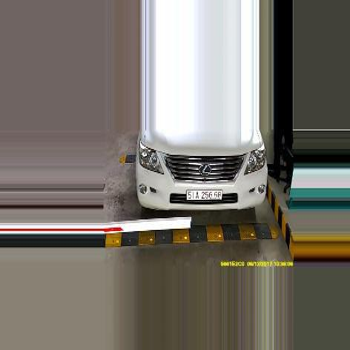

{'DocVQA': 'n08 au 777'}


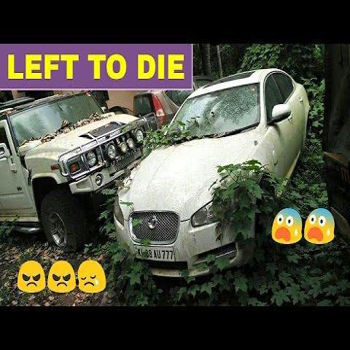

{'DocVQA': '522 9755'}


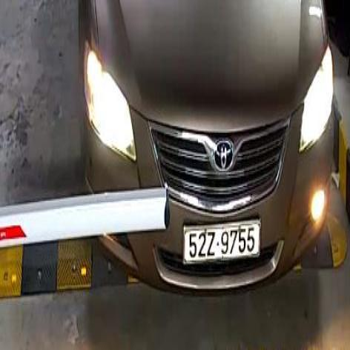

In [11]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer

# Test on the first 3 samples from the train dataset
for idx in range(3):
    sample = dataset["train"][idx]
    image = sample["image"]

    print(run_example("DocVQA", "What is the license plate number?", image))
    display(image.resize([350, 350]))


In [63]:
from torch.utils.data import Dataset

class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" + "What is the license plate number?"  # Changed question prompt
        answer = example['objects']  # Adjusted to match your dataset's format
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, answer, image


In [64]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

# Create datasets
train_dataset = DocVQADataset(ds_train)  # Kept logic, changed dataset variable
val_dataset = DocVQADataset(ds_test)  # Kept logic, changed dataset variable

# Create DataLoader
batch_size = 1  # No change
num_workers = 0  # No change

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)


In [65]:
import os
import torch
from torch.optim import AdamW
from tqdm import tqdm
from transformers import get_scheduler

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            inputs, objects = batch  # `objects` contain the labels from your dataset

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]

            labels = processor.tokenizer(
                text=[str(obj) for obj in objects],  # Convert objects to string for tokenization
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, objects = batch  # `objects` contain the labels

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]

                labels = processor.tokenizer(
                    text=[str(obj) for obj in objects],  # Convert objects to string
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


In [66]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

In [67]:
train_model(train_loader, val_loader, model, processor, epochs=3)

Training Epoch 1/3: 100%|██████████| 3/3 [01:55<00:00, 38.62s/it]


Average Training Loss: 6.934032122294108


Validation Epoch 1/3: 100%|██████████| 3/3 [00:28<00:00,  9.63s/it]


Average Validation Loss: 6.557951768239339


Training Epoch 2/3: 100%|██████████| 3/3 [01:46<00:00, 35.56s/it]


Average Training Loss: 6.720156192779541


Validation Epoch 2/3: 100%|██████████| 3/3 [00:28<00:00,  9.39s/it]


Average Validation Loss: 6.408172448476155


Training Epoch 3/3: 100%|██████████| 3/3 [01:44<00:00, 34.86s/it]


Average Training Loss: 6.630573749542236


Validation Epoch 3/3: 100%|██████████| 3/3 [00:27<00:00,  9.29s/it]


Average Validation Loss: 6.345789750417073


{'DocVQA': '5 1a256fr'}


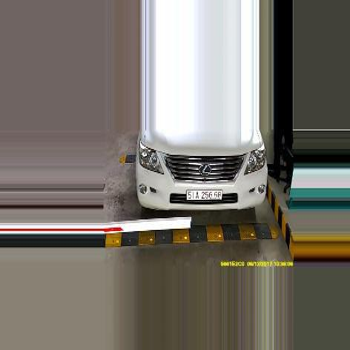

{'DocVQA': 'k 08 au 777'}


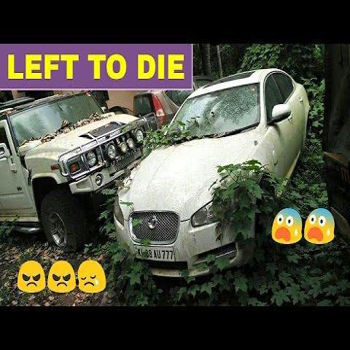

{'DocVQA': '522 9755'}


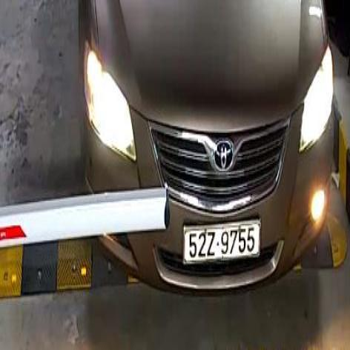

In [68]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer

# Test on the first 3 samples from the train dataset
for idx in range(3):
    sample = dataset["train"][idx]
    image = sample["image"]

    print(run_example("DocVQA", "What is the license plate number?", image))
    display(image.resize([350, 350]))


In [69]:
import os
import torch

# ✅ Define save directory
save_dir = "./florence_finetuned"

# ✅ Ensure directory exists
os.makedirs(save_dir, exist_ok=True)

# ✅ Save model and processor properly
model.save_pretrained(save_dir, safe_serialization=True)  # Use `safe_serialization=True`
processor.save_pretrained(save_dir)

# ✅ Clear CUDA cache to free memory
torch.cuda.empty_cache()

print(f"✅ Model and processor saved to {save_dir}")


✅ Model and processor saved to ./florence_finetuned


Testing Model: 100%|██████████| 3/3 [00:35<00:00, 11.81s/it]



🔍 **Model Performance on Test Dataset**
✅ Accuracy:  0.0000
✅ Precision: 0.0000
✅ Recall:    0.0000
✅ F1 Score:  0.0000

📌 **Example Prediction:**
📷 Image ID: 1480
✅ True Answer: {'id': [1546], 'area': [728], 'bbox': [[250.0, 162.0, 56.0, 13.0]], 'category': [0]}
🔍 Predicted Answer: {'DocVQA': '5 1a256fr'}


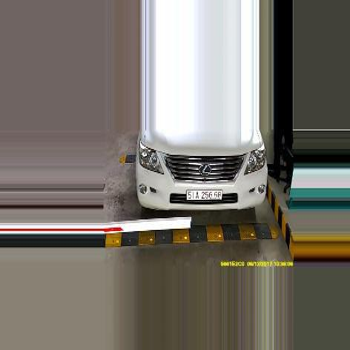


📌 **Example Prediction:**
📷 Image ID: 1457
✅ True Answer: {'id': [1517], 'area': [1550], 'bbox': [[180.0, 249.0, 62.0, 25.0]], 'category': [0]}
🔍 Predicted Answer: {'DocVQA': 'k 08 au 777'}


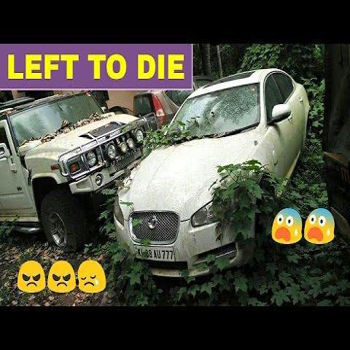


📌 **Example Prediction:**
📷 Image ID: 223
✅ True Answer: {'id': [234], 'area': [4949], 'bbox': [[249.0, 186.0, 101.0, 49.0]], 'category': [0]}
🔍 Predicted Answer: {'DocVQA': '522 9755'}


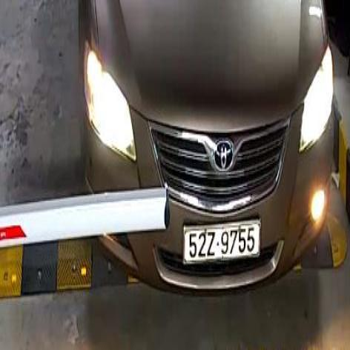

In [70]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# ✅ Lists to store true and predicted values
y_true = []
y_pred = []

# ✅ Test on the test dataset
for sample in tqdm(dataset["test"], desc="Testing Model"):
    image = sample["image"]
    ground_truth = sample["objects"]  # The correct license plate number

    # Use the same `run_example()` function to get predictions
    predicted_answer = run_example("DocVQA", "What is the license plate number?", image)

    # Store results for evaluation
    y_true.append(str(ground_truth).lower())  # Convert to lowercase for consistency
    y_pred.append(str(predicted_answer).lower())

# ✅ Compute Performance Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

# ✅ Print Evaluation Results
print("\n🔍 **Model Performance on Test Dataset**")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

# ✅ Show Sample Predictions for Verification
for idx in range(3):  # Display 3 test samples
    sample = dataset["test"][idx]
    image = sample["image"]

    print("\n📌 **Example Prediction:**")
    print(f"📷 Image ID: {sample['image_id']}")
    print(f"✅ True Answer: {sample['objects']}")
    print(f"🔍 Predicted Answer: {run_example('DocVQA', 'What is the license plate number?', image)}")

    display(image.resize([350, 350]))  # Show image for visual verification


Detected Answer: {'DocVQA': '5 1a256fr'}
Detected License Plate: 


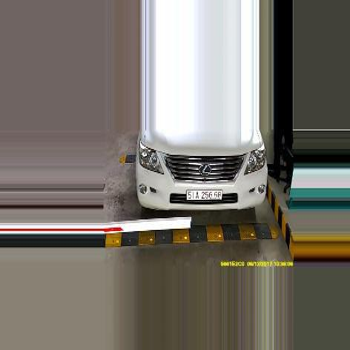

Detected Answer: {'DocVQA': 'k 08 au 777'}
Detected License Plate: 


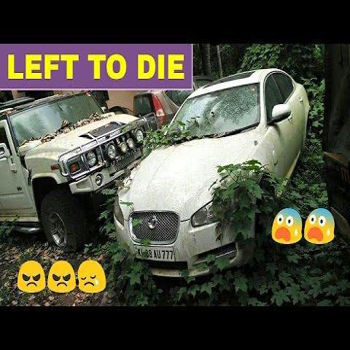

Detected Answer: {'DocVQA': '522 9755'}
Detected License Plate: 522:


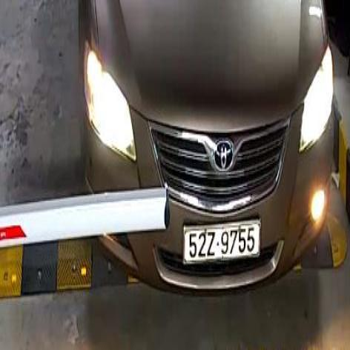

In [71]:
import easyocr
import cv2
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq
import numpy as np  # Import numpy and alias as np


# Initialize EasyOCR Reader
ocr_reader = easyocr.Reader(['en'])  # Set the language to English

# Your run_example function updated with EasyOCR
def run_example_with_ocr(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    # Preprocess the image for the model
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

    # Generate the model output
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))

    # Extract the region containing the number plate from the image (You can modify this to target your detected region)
    # Assuming the number plate region is obtained after detection:
    # Example, for simplicity, let's assume the region is known. You can get this from model output (bounding boxes)

    # Here you would extract the bounding box (x, y, width, height) of the number plate from model's output
    # For demo, we assume you have a method or hardcoded values for the bounding box of detected plate

    # Example coordinates for a bounding box (this is just a placeholder)
    plate_bounding_box = (50, 200, 300, 250)  # (x, y, width, height)

    # Crop the image to the number plate region
    plate_image = image.crop(plate_bounding_box)

    # Convert the cropped image to OpenCV format for OCR processing
    plate_image_cv = cv2.cvtColor(np.array(plate_image), cv2.COLOR_RGB2BGR)

    # Run EasyOCR on the cropped image (number plate)
    ocr_result = ocr_reader.readtext(plate_image_cv)

    # Extract text from OCR result (if OCR found text)
    plate_number = ""
    if ocr_result:
        plate_number = " ".join([text[1] for text in ocr_result])

    return parsed_answer, plate_number

# Test on the first 3 samples from the train dataset
for idx in range(3):
    sample = dataset["train"][idx]
    image = sample["image"]

    parsed_answer, plate_number = run_example_with_ocr("DocVQA", "What is the license plate number?", image)

    print(f"Detected Answer: {parsed_answer}")
    print(f"Detected License Plate: {plate_number}")
    display(image.resize([350, 350]))


In [72]:
import numpy as np
import easyocr
from sklearn.metrics import precision_recall_fscore_support
import Levenshtein
from jiwer import wer, cer
from tqdm import tqdm

# Initialize EasyOCR Reader
ocr_reader = easyocr.Reader(['en'])  # Set the language to English

# Function to calculate precision, recall, F1, CER, WER, and Levenshtein distance
def evaluate_metrics(predicted_text, actual_text):
    # Convert inputs to strings for comparison
    predicted_text = str(predicted_text)
    actual_text = str(actual_text)

    # Precision, Recall, F1 (treating as binary classification - match or no match)
    precision, recall, f1, _ = precision_recall_fscore_support(
        [actual_text], [predicted_text], average='binary', zero_division=1,
        pos_label=actual_text  # Treat the actual text as the positive label
    )

    # Character Error Rate (CER)
    cer_score = cer(actual_text, predicted_text)

    # Word Error Rate (WER)
    wer_score = wer(actual_text, predicted_text)

    # Levenshtein Distance
    levenshtein_distance = Levenshtein.distance(actual_text, predicted_text)

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "cer": cer_score,
        "wer": wer_score,
        "levenshtein_distance": levenshtein_distance
    }

# Function to test OCR on dataset and collect results
def evaluate_ocr_on_dataset(dataset, ocr_reader):
    all_metrics = {
        "precision": [],
        "recall": [],
        "f1_score": [],
        "cer": [],
        "wer": [],
        "levenshtein_distance": []
    }

    for split in ['train', 'validation', 'test']:  # Evaluate on train, validation, and test splits
        print(f"Evaluating on {split} dataset...")

        for idx in tqdm(range(len(dataset[split]))):
            sample = dataset[split][idx]
            image = sample["image"]
            ground_truth = sample["objects"]  # The license plate number from the ground truth

            # Print out the ground truth to inspect its structure
            print(f"Ground truth for index {idx}: {ground_truth}")

            # Extract the license plate number from the ground truth
            actual_license_plate = None

            if isinstance(ground_truth, list):
                for obj in ground_truth:
                    if isinstance(obj, dict) and 'bbox' in obj:
                        # The ground truth text might be missing, handle this case
                        if 'license_plate_text' in obj:
                            actual_license_plate = obj['license_plate_text']
                        break
            elif isinstance(ground_truth, str):  # Handle the case where ground truth is just a string
                actual_license_plate = ground_truth

            # If there's no actual text for the license plate, use a placeholder and print a message
            if actual_license_plate is None:
                print(f"Warning: Ground truth text is missing for sample {idx}. Using fallback prediction.")
                actual_license_plate = "UNKNOWN"

            # Run OCR
            plate_image_cv = np.array(image)  # Convert image to numpy array for easyocr
            ocr_result = ocr_reader.readtext(plate_image_cv)

            # If OCR found some text
            if ocr_result:
                # Get the detected text from OCR results
                predicted_text = " ".join([text[1] for text in ocr_result])
            else:
                predicted_text = "UNKNOWN"  # Use a fallback text if OCR fails

            # Evaluate metrics only if valid predictions are available
            if predicted_text != "UNKNOWN" and actual_license_plate != "UNKNOWN":
                metrics = evaluate_metrics(predicted_text, actual_license_plate)
            else:
                metrics = {
                    "precision": 0.0,
                    "recall": 0.0,
                    "f1_score": 0.0,
                    "cer": 1.0,  # Max CER if prediction is totally incorrect
                    "wer": 1.0,  # Max WER if prediction is totally incorrect
                    "levenshtein_distance": len(actual_license_plate)  # Max Levenshtein distance
                }

            # Append metrics to the results
            for key in all_metrics:
                all_metrics[key].append(metrics[key])

        # Calculate and print the average metrics for each dataset split
        avg_metrics = {key: np.mean(all_metrics[key]) for key in all_metrics}
        print(f"Average metrics for {split} dataset:")
        for metric, value in avg_metrics.items():
            print(f"{metric}: {value:.4f}")  # Show results with 4 decimal points
        print("-" * 50)

# Assuming `dataset` is already loaded with your DatasetDict
evaluate_ocr_on_dataset(dataset, ocr_reader)


Evaluating on train dataset...


  0%|          | 0/3 [00:00<?, ?it/s]

Ground truth for index 0: {'id': [1546], 'area': [728], 'bbox': [[250.0, 162.0, 56.0, 13.0]], 'category': [0]}


 33%|███▎      | 1/3 [00:03<00:06,  3.20s/it]

Ground truth for index 1: {'id': [1517], 'area': [1550], 'bbox': [[180.0, 249.0, 62.0, 25.0]], 'category': [0]}


 67%|██████▋   | 2/3 [00:06<00:03,  3.20s/it]

Ground truth for index 2: {'id': [234], 'area': [4949], 'bbox': [[249.0, 186.0, 101.0, 49.0]], 'category': [0]}


100%|██████████| 3/3 [00:08<00:00,  2.74s/it]


Average metrics for train dataset:
precision: 0.0000
recall: 0.0000
f1_score: 0.0000
cer: 1.0000
wer: 1.0000
levenshtein_distance: 7.0000
--------------------------------------------------
Evaluating on validation dataset...


  0%|          | 0/3 [00:00<?, ?it/s]

Ground truth for index 0: {'id': [1546], 'area': [728], 'bbox': [[250.0, 162.0, 56.0, 13.0]], 'category': [0]}


 33%|███▎      | 1/3 [00:02<00:05,  2.80s/it]

Ground truth for index 1: {'id': [1517], 'area': [1550], 'bbox': [[180.0, 249.0, 62.0, 25.0]], 'category': [0]}


 67%|██████▋   | 2/3 [00:05<00:02,  2.92s/it]

Ground truth for index 2: {'id': [234], 'area': [4949], 'bbox': [[249.0, 186.0, 101.0, 49.0]], 'category': [0]}


100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


Average metrics for validation dataset:
precision: 0.0000
recall: 0.0000
f1_score: 0.0000
cer: 1.0000
wer: 1.0000
levenshtein_distance: 7.0000
--------------------------------------------------
Evaluating on test dataset...


  0%|          | 0/3 [00:00<?, ?it/s]

Ground truth for index 0: {'id': [1546], 'area': [728], 'bbox': [[250.0, 162.0, 56.0, 13.0]], 'category': [0]}


 33%|███▎      | 1/3 [00:03<00:06,  3.30s/it]

Ground truth for index 1: {'id': [1517], 'area': [1550], 'bbox': [[180.0, 249.0, 62.0, 25.0]], 'category': [0]}


 67%|██████▋   | 2/3 [00:06<00:03,  3.36s/it]

Ground truth for index 2: {'id': [234], 'area': [4949], 'bbox': [[249.0, 186.0, 101.0, 49.0]], 'category': [0]}


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]

Average metrics for test dataset:
precision: 0.0000
recall: 0.0000
f1_score: 0.0000
cer: 1.0000
wer: 1.0000
levenshtein_distance: 7.0000
--------------------------------------------------
